In [1]:
import io
import re
import asyncio

from tqdm.auto import tqdm
import pandas as pd
from dotenv import load_dotenv
import openai
import tiktoken  # Estimate OpenAI tokens

load_dotenv("../.env")
client = openai.OpenAI()

In [10]:
df = pd.read_csv("../data/ellipse_corpus_w_splits_prompts_utf8.csv", index_col=0)
df.index.name = None  # Remove index name

# Clean up unicode garbage in prompts
df["assignment"] = df["assignment"].apply(
    lambda x: x.encode("ascii", "ignore").decode("ascii")
)
df

,Filename,Cohesion,Source,Prompt_name,Grade,ELL,Race_Ethnicity,Gender,SES,split,full_text,assignment
1,2021000501,3.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Economically disadvantaged,testing,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Imagine your school is deciding on a new cell ...
2,2021000535,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Economically disadvantaged,testing,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Imagine your school is deciding on a new cell ...
3,2021000667,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Economically disadvantaged,training,PHONES\n\nDear principal students should have ...,Imagine your school is deciding on a new cell ...
4,2021000683,2.0,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Economically disadvantaged,training,phones\n\ni think phones should be allowed in ...,Imagine your school is deciding on a new cell ...
5,2021000705,2.0,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Not economically disadvantaged,training,Do you really think students need cell phones ...,Imagine your school is deciding on a new cell ...
...,...,...,...,...,...,...,...,...,...,...,...,...
6478,AAAXMP138200002211022133_OR,4.0,Virginia,Controlling extracurricular involvement,12,Yes,Hispanic/Latino,M,Economically disadvantaged,training,The decision regarding extracurricular involve...,Many students become involved in extracurricul...
6479,AAAXMP138200002211062115_OR,3.5,Virginia,Lunch menus,12,Yes,Asian/Pacific Islander,M,Economically disadvantaged,training,"The school plans to change to a new, healthier...",Imagine your school cafeteria plans to change ...
6480,AAAXMP138200002211752151_OR,4.0,Virginia,Curfews for teenagers,12,Yes,Asian/Pacific Islander,F,Not economically disadvantaged,training,I raised by my grandparents and they always to...,A city council is debating the adoption of a 1...
6481,AAAXMP138200002214212144_OR,3.5,Virginia,Summer projects,12,Yes,Asian/Pacific Islander,F,Economically disadvantaged,training,Imagine the world if students didn't complete ...,Some schools require students to complete summ...


## Construct Finetuning Inputs

Format the training data as a JSONL file with the following structure:
```
{
    "messages": [
        {
            "role": "user",
            "content": "Prompt + Text"
        },
        {
            "role": "assistant",
            "content": "The Cohesion score of the essay (1-5)"
        }
    ]
}
```

In [14]:
def construct_samples(dataframe):
    samples = []
    for row in dataframe.itertuples():
        sample = {
            "messages": [
                {
                    "role": "user",
                    "content": f"# Prompt\n{row.assignment}\n\n\n# Student Response\n{row.full_text}",
                },
                {
                    "role": "assistant",
                    "content": str(row.Cohesion),
                },
            ]
        }
        samples.append(sample)

    return pd.DataFrame(samples)


train_samples = construct_samples(df[df["split"] == "training"])
dev_samples = construct_samples(df[df["split"] == "validation"])

train_samples.to_json(
    "../bin/ellipse_cohesion_train.jsonl", orient="records", lines=True
)
dev_samples.to_json("../bin/ellipse_cohesion_dev.jsonl", orient="records", lines=True)

print(train_samples["messages"].sample(1).item())
print("-" * 80)
print(train_samples["messages"].sample(1).item()[0]["content"])
print("-" * 80)
display(train_samples)

[{'role': 'user', 'content': "# Prompt\nWhat is something you would like to accomplish in the future? Perhaps you would like to learn how to play an instrument, graduate at the top of your class, or visit the ocean. Identify one thing you would like to accomplish, and include specific details and examples to help explain why it is important. (OMIT FOR MANY EXAMPLES)\n\n\n# Student Response\nWe all have our own goals that we would like to accomplish in the future. Perhaps you still want the same thing as when you were a kid, maybe the technology has changed your plans. I personally want my dream to go to college accomplished by the future, get a career, high education, be the first one in my family that has gone to college.\n\nFirst of all going to college can help me get the career I want which is game designing. game designing is a career I have wanted to get since I turned twelve years old when I first started playing minecraft. Minecfrat is an awesome game where you can build really

,messages
0,"[{'role': 'user', 'content': '# Prompt Imagine..."
1,"[{'role': 'user', 'content': '# Prompt Imagine..."
2,"[{'role': 'user', 'content': '# Prompt Imagine..."
3,"[{'role': 'user', 'content': '# Prompt Imagine..."
4,"[{'role': 'user', 'content': '# Prompt Imagine..."
...,...
3727,"[{'role': 'user', 'content': '# Prompt Many st..."
3728,"[{'role': 'user', 'content': '# Prompt Imagine..."
3729,"[{'role': 'user', 'content': '# Prompt A city ..."
3730,"[{'role': 'user', 'content': '# Prompt Some sc..."


## Creat Finetuning Job in OpenAI

In [15]:
# Collect Datasets
with open("../bin/ellipse_cohesion_train.jsonl", "rb") as file:
    train_response = client.files.create(file=file, purpose="fine-tune")

with open("../bin/ellipse_cohesion_dev.jsonl", "rb") as file:
    dev_response = client.files.create(file=file, purpose="fine-tune")

print(f"Training File ID: {train_response.id}")
print(f"Development File ID: {dev_response.id}")

Training File ID: file-RSvFDSGaTXCJyjVbeGfSMn
Development File ID: file-LyHuedfDJPEfXzCeLbD9dR


In [16]:
# Start job
response = client.fine_tuning.jobs.create(
    training_file=train_response.id,
    validation_file=dev_response.id,
    model="gpt-4.1-nano-2025-04-14",
    suffix="ellipse-cohesion-scoring",
)

job_id = response.id

print("Job ID:", response.id)
print("Status:", response.status)

Job ID: ftjob-g3afBWYycyKkK9j1UOJ6Djb8
Status: validating_files


In [18]:
# Check finetuning job status
client.fine_tuning.jobs.retrieve("ftjob-g3afBWYycyKkK9j1UOJ6Djb8")

FineTuningJob(id='ftjob-g3afBWYycyKkK9j1UOJ6Djb8', created_at=1758471418, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4.1-nano-2025-04-14:ai-aloe-georgia-institute-of-technology:ellipse-cohesion-scoring:CIHmZwU6', finished_at=1758474292, hyperparameters=Hyperparameters(batch_size=7, learning_rate_multiplier=0.1, n_epochs=3), model='gpt-4.1-nano-2025-04-14', object='fine_tuning.job', organization_id='org-T8buG9LSyviQmc1hjja0RRCV', result_files=['file-CZtk5JFuxsmJTLuv6bVhZP'], seed=2011856927, status='succeeded', trained_tokens=6163011, training_file='file-RSvFDSGaTXCJyjVbeGfSMn', validation_file='file-LyHuedfDJPEfXzCeLbD9dR', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=7, learning_rate_multiplier=0.1, n_epochs=3)), type='supervised'), user_provided_suffix='ellipse-cohesion-scoring', metadata=None, usage_metrics=None, shared_with_openai=False, eval_id=

In [19]:
# Retrieve the fine tuned model id
results = client.fine_tuning.jobs.list()
finetuned_model = results.data[0].fine_tuned_model
print(finetuned_model)

ft:gpt-4.1-nano-2025-04-14:ai-aloe-georgia-institute-of-technology:ellipse-cohesion-scoring:CIHmZwU6


## Inference

In [22]:
responses = []
test_frame = df[df["split"] == "testing"]
for row in tqdm(test_frame.itertuples(), total=len(test_frame)):
    response = client.chat.completions.create(
        model=finetuned_model,
        messages=[
            {
                "role": "user",
                "content": f"# Prompt\n{row.assignment}\n\n\n# Student Response\n{row.full_text}",
            }
        ],
    )
    responses.append(response)

  0%|          | 0/1921 [00:00<?, ?it/s]

## Collect results
And attach to dataframe

In [26]:
response_contents = [
    chat_completion.choices[0].message.content for chat_completion in responses
]

# Collect scores
scores_4_1_nano = [score for score in response_contents]

In [29]:
# Some scores are poorly formatted or include multiple values
display(pd.Series(scores_4_1_nano).value_counts())

# Selecting the first three characters for each score will return a valid floating point value
scores_4_1_nano = [float(score[:3]) for score in response_contents]

3.0                              599
3.5                              506
2.5                              357
4.0                              247
2.0                              155
4.5                               43
5.0                                5
1.5                                2
1.0                                2
2.5/3.0                            1
2.5\n\n2.0                         1
3.5  \n3.0  \n3.0                  1
2.5\n\n2.5\n\n2.5                  1
2.5/4.0\n\n2.0/3.0\n\n2.5/3.0      1
Name: count, dtype: int64

In [30]:
df.loc[df["split"] == "testing", "4_1_nano_finetuned_score"] = scores_4_1_nano
df[df["split"] == "testing"]

,Filename,Cohesion,Source,Prompt_name,Grade,ELL,Race_Ethnicity,Gender,SES,split,full_text,assignment,4_1_nano_finetuned_score
1,2021000501,3.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Economically disadvantaged,testing,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Imagine your school is deciding on a new cell ...,3.5
2,2021000535,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Economically disadvantaged,testing,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Imagine your school is deciding on a new cell ...,3.0
7,2021000756,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Not economically disadvantaged,testing,dear TEACHER_NAME i think the you should let s...,Imagine your school is deciding on a new cell ...,2.0
10,2021001060,1.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Economically disadvantaged,testing,dear principal\n\ni believe that you should al...,Imagine your school is deciding on a new cell ...,2.0
13,2021002805,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Economically disadvantaged,testing,to: TEACHER_NAME\n\nADDRESS_NAME\n\nSCHOOL_NAM...,Imagine your school is deciding on a new cell ...,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6465,AAAXMP138200002200562850_OR,2.5,Virginia,Mandatory extracurricular activities,8,Yes,Asian/Pacific Islander,F,Economically disadvantaged,testing,I disagree about what the principal has decide...,Your principal has decided that all students m...,2.5
6466,AAAXMP138200002200972850_OR,3.5,Virginia,Mandatory extracurricular activities,8,Yes,Hispanic/Latino,F,Economically disadvantaged,testing,Your principal has decided all students must p...,Your principal has decided that all students m...,3.0
6467,AAAXMP138200002201282125_OR,3.0,Virginia,Distance learning,9,Yes,Black/African American,M,Economically disadvantaged,testing,"for me i can say many student they can't,not d...",Some schools offer distance learning as an opt...,2.0
6472,AAAXMP138200002205382127_OR,3.0,Virginia,Career commitment,10,Yes,Asian/Pacific Islander,F,Economically disadvantaged,testing,Career is the most important in people life. i...,"In some societies, students are expected to id...",3.0


## Save Results

Merge results with dataframe produced in `./1a-openai-batch-score.ipynb` and save.

In [31]:
df.to_csv("../results/ellipse_w_4_1_nano_scores.csv")
df

,Filename,Cohesion,Source,Prompt_name,Grade,ELL,Race_Ethnicity,Gender,SES,split,full_text,assignment,4_1_nano_finetuned_score
1,2021000501,3.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Economically disadvantaged,testing,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Imagine your school is deciding on a new cell ...,3.5
2,2021000535,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Economically disadvantaged,testing,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Imagine your school is deciding on a new cell ...,3.0
3,2021000667,2.5,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Economically disadvantaged,training,PHONES\n\nDear principal students should have ...,Imagine your school is deciding on a new cell ...,NaN
4,2021000683,2.0,NCES,Cell phones at school,8,Yes,Hispanic/Latino,M,Economically disadvantaged,training,phones\n\ni think phones should be allowed in ...,Imagine your school is deciding on a new cell ...,NaN
5,2021000705,2.0,NCES,Cell phones at school,8,Yes,Hispanic/Latino,F,Not economically disadvantaged,training,Do you really think students need cell phones ...,Imagine your school is deciding on a new cell ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6478,AAAXMP138200002211022133_OR,4.0,Virginia,Controlling extracurricular involvement,12,Yes,Hispanic/Latino,M,Economically disadvantaged,training,The decision regarding extracurricular involve...,Many students become involved in extracurricul...,NaN
6479,AAAXMP138200002211062115_OR,3.5,Virginia,Lunch menus,12,Yes,Asian/Pacific Islander,M,Economically disadvantaged,training,"The school plans to change to a new, healthier...",Imagine your school cafeteria plans to change ...,NaN
6480,AAAXMP138200002211752151_OR,4.0,Virginia,Curfews for teenagers,12,Yes,Asian/Pacific Islander,F,Not economically disadvantaged,training,I raised by my grandparents and they always to...,A city council is debating the adoption of a 1...,NaN
6481,AAAXMP138200002214212144_OR,3.5,Virginia,Summer projects,12,Yes,Asian/Pacific Islander,F,Economically disadvantaged,training,Imagine the world if students didn't complete ...,Some schools require students to complete summ...,NaN


In [34]:
df[["Cohesion", "4_1_nano_finetuned_score"]].corr()

,Cohesion,4_1_nano_finetuned_score
Cohesion,1.000000,0.554177
4_1_nano_finetuned_score,0.554177,1.000000


## Quick Viz

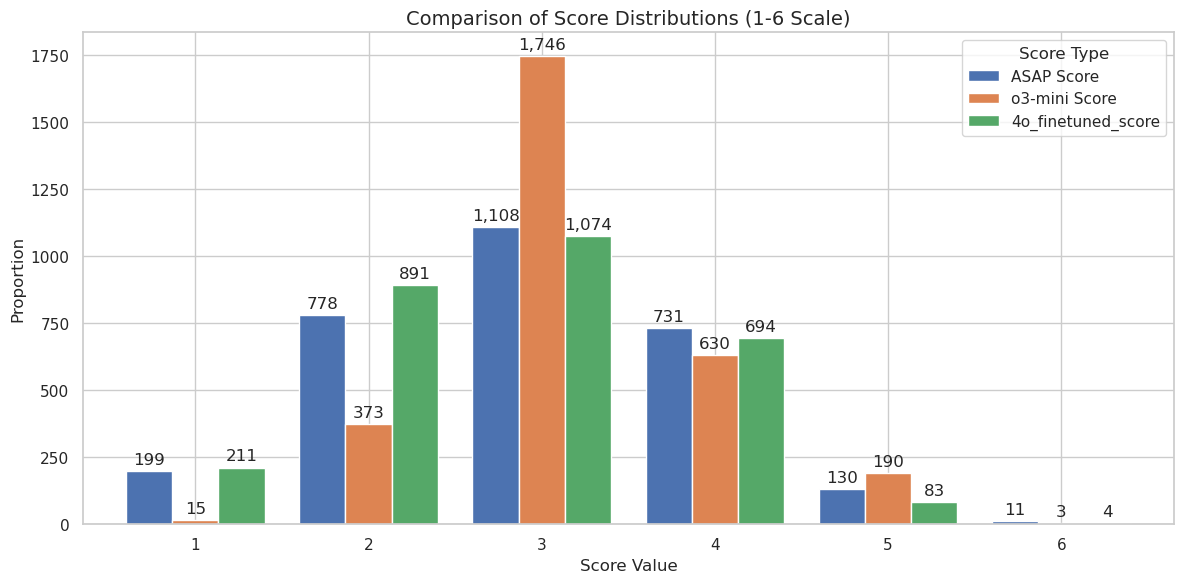

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

test_df = out_df.loc[out_df["stratified_split"] == "test"]

# Calculate the frequency counts for each score (1-6)
score_counts = test_df["score"].value_counts().reindex(range(1, 7), fill_value=0)
o3_mini_counts = (
    test_df["o3_mini_score"].value_counts().reindex(range(1, 7), fill_value=0)
)
finetuned_counts = (
    test_df["4o_finetuned_score"].value_counts().reindex(range(1, 7), fill_value=0)
)

# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "ASAP Score": score_counts.values,
        "o3-mini Score": o3_mini_counts.values,
        "4o_finetuned_score": finetuned_counts.values,
    },
    index=range(1, 7),
)

# Create the side-by-side bar chart
ax = plot_data.plot(kind="bar", width=0.8, figsize=(12, 6))

# Add labels and title
plt.xlabel("Score Value", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.title("Comparison of Score Distributions (1-6 Scale)", fontsize=14)
plt.xticks(rotation=0)  # Keep x-labels horizontal

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="{:,.0f}", padding=3)

plt.legend(title="Score Type")
plt.tight_layout()
plt.show();